### Dataset Creation

This file prepares a dataframe of 10,000+ tracks across 100 Spotify playlists along with metadata (which playlist the track is from, track name, artist, album, lyrics, etc.)

First, download [The Million Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge), which contains 1 million playlists created by Spotify users in the US between Jan 2010 - Oct 2017.

From the dataset, we will select 100 playlists that each have at least 100 songs.

However, the dataset does not contain track lyrics, which we need for this project. To get track lyrics, we will use the [LRCLIB](https://lrclib.net/) API to retrieve song lyrics for all unique songs across the 100 playlists.

In [16]:
import json
import matplotlib.pyplot as plt
import requests  # for API calls
import pandas as pd

#### Access playlists with at least 150 tracks from the Million Playlist Dataset

In [17]:
# First 1000 playlists from the Million Playlist Dataset 
filepath = 'data/mpd.slice.0-999.json'

# Load the json file
with open(filepath, 'r') as f:
    data = json.load(f)

In [21]:
# Iterate through 1000 playlists, saving the contents of the "valid" playlists, the ones that have at least 150 tracks
# We want minimum 100 playlists with 100 tracks each (to get a total of 10,000 tracks)
# We will overshoot because it may not be possible to obtain lyrics from all tracks in each playlist
valid_playlists = []

for playlist in data['playlists']:
    if playlist['num_tracks'] > 149:
        valid_playlists.append(playlist)

print("Number of playlists with at least 150 tracks:", len(valid_playlists))
print("The first valid playlist:", valid_playlists[0])

Number of playlists with at least 150 tracks: 102
The first valid playlist: {'name': 'Garage Rock', 'collaborative': 'false', 'pid': 30, 'modified_at': 1430265600, 'num_tracks': 157, 'num_albums': 17, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Will Butler', 'track_uri': 'spotify:track:6v4zAuJTlszNdKrbbnEFu8', 'artist_uri': 'spotify:artist:1POwuKLQ9xhMZzIYElNtWp', 'track_name': 'Take My Side', 'album_uri': 'spotify:album:3skSkUIi340Fp7KzUAxTBW', 'duration_ms': 228563, 'album_name': 'Policy'}, {'pos': 1, 'artist_name': 'Parquet Courts', 'track_uri': 'spotify:track:25JD35LDh7CEJ9gKUNruVj', 'artist_uri': 'spotify:artist:23NIwARd4vPbxt3wwNnJ6k', 'track_name': 'Everyday it Starts', 'album_uri': 'spotify:album:0Zj7AxTX3Q312lz6GLFTrt', 'duration_ms': 176026, 'album_name': 'Content Nausea'}, {'pos': 2, 'artist_name': 'Parquet Courts', 'track_uri': 'spotify:track:24bk2iKzr3VcymFnzIy3oS', 'artist_uri': 'spotify:artist:23NIwARd4vPbxt3wwNnJ6k', 'track_name': 'Content Nausea', 'album_

#### Perform API calls to get lyrics of all tracks

In [22]:
# Function that performs an API call to LRCLIB to request song lyrics, given certain parameters

def request_lyrics(track_name, artist_name, album_name, duration_sec):
    url = 'https://lrclib.net/api/get'
    parameters = {"track_name": track_name,
                  "artist_name": artist_name,
                  "album_name": album_name,
                  "duration": duration_sec}
    
    # Make the request
    response = requests.get(url, params=parameters)
    
    # If successful, return string containing lyrics
    if response.status_code == 200:
        data = response.json()
        # Response contains a field called 'plainLyrics' with string value
        return data['plainLyrics']
    
    # If unsuccessful, return 0
    else:
        return 0

In [ ]:
# # TEST: Testing successful API Call, the 'request_lyrics' function

# p = data['playlists'][0]  # first playlist
# t = p['tracks'][0]  # first track

# # Extract parameters for API call for lyrics
# track_name = t['track_name']
# artist_name = t['artist_name']
# album_name = t['album_name']
# duration_sec = int(t['duration_ms'] / 1000)

# # API call to get lyrics
# lyrics = request_lyrics(track_name, artist_name, album_name, duration_sec)
# lyrics

In [ ]:
# # TEST: Testing API call that returns 'None' for lyrics (e.g. for an instrumental track)

# lyrics = request_lyrics('Urban Ease', 'Parquet Courts', 'Content Nausea', 55)
# print(lyrics)

In [23]:
# WARNING: THIS CELL TAKES AROUND 30 MINUTES TO RUN!

# Create a list of unique tracks across all "valid" playlists, along with their metadata
# During this process, make API calls to also obtain the lyrics of these tracks
# Note: Tracks may be removed from playlists if lyrics are unable to be obtained, but we were able to successfully obtain lyrics for all tracks

unique_tracks = []

track_count = 0  # verbose for debugging
processed_playlists_count = 0

for playlist in valid_playlists:
    if track_count < 10000:  # process playlist only if we need more tracks
        processed_playlists_count += 1
        print("Processing playlist", processed_playlists_count, "of ~100. On track", track_count, "of ~10,000.")  # verbose for debugging
        
        for t in playlist['tracks'][:150]:  # only take the first 150 tracks of each playlist
            track_uri = t['track_uri']
            
            # Check if we encountered this track before
            # If so, and make note if it is in a different playlist
            new_track = True
            for tr in unique_tracks:
                if tr['track_uri'] == track_uri:
                    # If track is NOT a repeat in same playlist
                    if playlist['pid'] not in tr['playlist_ids']:
                        tr['playlist_ids'].append(playlist['pid'])
                        tr['playlist_names'].append(playlist['name'])
                    
                    # Update vars
                    new_track = False
                    track_count += 1  # verbose for debugging
                    break
            
            # We encounter a new track
            if new_track:
                # Extract parameters for API call for lyrics
                track_name = t['track_name']
                artist_name = t['artist_name']
                album_name = t['album_name']
                duration_sec = int(t['duration_ms'] / 1000)
                # API call to get lyrics
                lyrics = request_lyrics(track_name, artist_name, album_name, duration_sec)
                
                # Call was successful; add track and only the relevant metadata to 'unique_tracks' list
                if lyrics != 0 and lyrics is not None:  # API call fails if returns 0; API call returns 'None' if no lyrics (e.g. an instrumental track)
                    track = {}
                    track['playlist_ids'] = [playlist['pid']]
                    track['playlist_names'] = [playlist['name']]
                    track['track_name'] = track_name
                    track['artist_name'] = artist_name
                    track['album_name'] = album_name
                    track['track_uri'] = t['track_uri']
                    track['lyrics'] = lyrics
                    unique_tracks.append(track)
                    
                    track_count += 1  # verbose for debugging

                # Call was unsuccessful; skip this track
                else:
                    pass
        

Processing playlist 1 of ~100. On track 0 of ~10,000.


Processing playlist 2 of ~100. On track 141 of ~10,000.
Processing playlist 3 of ~100. On track 290 of ~10,000.
Processing playlist 4 of ~100. On track 437 of ~10,000.
Processing playlist 5 of ~100. On track 582 of ~10,000.
Processing playlist 6 of ~100. On track 719 of ~10,000.
Processing playlist 7 of ~100. On track 862 of ~10,000.
Processing playlist 8 of ~100. On track 995 of ~10,000.
Processing playlist 9 of ~100. On track 1137 of ~10,000.
Processing playlist 10 of ~100. On track 1271 of ~10,000.
Processing playlist 11 of ~100. On track 1415 of ~10,000.
Processing playlist 12 of ~100. On track 1564 of ~10,000.
Processing playlist 13 of ~100. On track 1705 of ~10,000.
Processing playlist 14 of ~100. On track 1845 of ~10,000.
Processing playlist 15 of ~100. On track 1992 of ~10,000.
Processing playlist 16 of ~100. On track 2133 of ~10,000.
Processing playlist 17 of ~100. On track 2283 of ~10,000.
Processing playlist 18 of ~100. On track 2422 of ~10,000.
Processing playlist 19 of ~10

#### Create dataframe with final dataset

In [25]:
# Organize the data into a dataframe of playlists (i.e. tracks can be appear several times in the df if they appear in different playlists)

print("Metadata fields for each track:", unique_tracks[0].keys())

# Iterate through list, creating a row of the dataframe for each playlist id
df_rows = []
for t in unique_tracks:
    for i in range(len(t['playlist_ids'])):
        row = {'Playlist ID': t['playlist_ids'][i],
               'Playlist Name': t['playlist_names'][i],
               'Track Name': t['track_name'],
               'Artist Name': t['artist_name'],
               'Album Name': t['album_name'],
               'Track URI': t['track_uri'],
               'Lyrics': t['lyrics']
               }
        df_rows.append(row)

sorted_rows = sorted(df_rows, key=lambda r: r['Playlist ID'])
df = pd.DataFrame(sorted_rows)

df.head()

Metadata fields for each track: dict_keys(['playlist_ids', 'playlist_names', 'track_name', 'artist_name', 'album_name', 'track_uri', 'lyrics'])


,Playlist ID,Playlist Name,Track Name,Artist Name,Album Name,Track URI,Lyrics
0,30,Garage Rock,Take My Side,Will Butler,Policy,spotify:track:6v4zAuJTlszNdKrbbnEFu8,Where's the fire? Let it burn\nWhere're the ch...
1,30,Garage Rock,Everyday it Starts,Parquet Courts,Content Nausea,spotify:track:25JD35LDh7CEJ9gKUNruVj,Everyday it starts\nEveryday it starts\nEveryd...
2,30,Garage Rock,Content Nausea,Parquet Courts,Content Nausea,spotify:track:24bk2iKzr3VcymFnzIy3oS,"Content nausea, World War Four\nSeems like it ..."
3,30,Garage Rock,Slide Machine,Parquet Courts,Content Nausea,spotify:track:7rjK8CDTtTn2KG9Zja7ETj,I've been down South where they use the slide ...
4,30,Garage Rock,Pretty Machines,Parquet Courts,Content Nausea,spotify:track:1zPn4tfkWfowVG3ROo1wUY,"Ah, moonlight\nIt's hard to believe it\nAnd it..."


#### Remove Outliers (playlists with < 100 tracks)

From the histogram below, we see that there is one main outlier that less than 100 tracks. It originally had at least 150 tracks (from our filtering at the beginning), but most of their songs were removed due to absence of lyrics.

Let's remove any such outlier playlists to retain consistency in number of tracks per playlist, as much as possible.

Number of playlists: 73
Mean number of tracks per playlist: 135.6986301369863
Standard deviation of tracks per playlist: 17.04950710553994
Max number of tracks per playlist: 150
Min number of tracks per playlist: 19


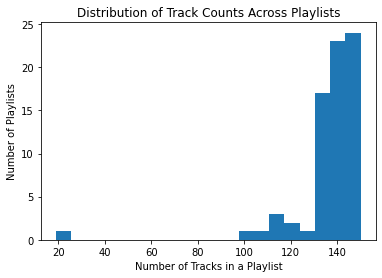

In [31]:
# Distribution of tracks across playlists

print("Number of playlists:", df['Playlist ID'].nunique())
tracks_per_playlist = df.groupby('Playlist ID').size()
print("Mean number of tracks per playlist:", tracks_per_playlist.mean())
print("Standard deviation of tracks per playlist:", tracks_per_playlist.std())
print("Max number of tracks per playlist:", max(tracks_per_playlist))
print("Min number of tracks per playlist:", min(tracks_per_playlist))

# Plot
plt.hist(tracks_per_playlist, bins=20)
plt.xlabel('Number of Tracks in a Playlist')
plt.ylabel('Number of Playlists')
plt.title('Distribution of Track Counts Across Playlists')
plt.show()

In [32]:
keep_playlists = tracks_per_playlist[tracks_per_playlist > 99].index
final_df = df[df['Playlist ID'].isin(keep_playlists)]

print("Number of removed playlists:", df['Playlist ID'].nunique() - final_df['Playlist ID'].nunique())

final_df.head()


Number of removed playlists: 1


,Playlist ID,Playlist Name,Track Name,Artist Name,Album Name,Track URI,Lyrics
0,30,Garage Rock,Take My Side,Will Butler,Policy,spotify:track:6v4zAuJTlszNdKrbbnEFu8,Where's the fire? Let it burn\nWhere're the ch...
1,30,Garage Rock,Everyday it Starts,Parquet Courts,Content Nausea,spotify:track:25JD35LDh7CEJ9gKUNruVj,Everyday it starts\nEveryday it starts\nEveryd...
2,30,Garage Rock,Content Nausea,Parquet Courts,Content Nausea,spotify:track:24bk2iKzr3VcymFnzIy3oS,"Content nausea, World War Four\nSeems like it ..."
3,30,Garage Rock,Slide Machine,Parquet Courts,Content Nausea,spotify:track:7rjK8CDTtTn2KG9Zja7ETj,I've been down South where they use the slide ...
4,30,Garage Rock,Pretty Machines,Parquet Courts,Content Nausea,spotify:track:1zPn4tfkWfowVG3ROo1wUY,"Ah, moonlight\nIt's hard to believe it\nAnd it..."


#### Exploratory analysis of final dataset

In [33]:
# Statistics

print("Number of total tracks:", len(final_df))
print("Number of playlists:", final_df['Playlist ID'].nunique())

tracks_per_plist = final_df.groupby('Playlist ID').size()

print("Mean number of tracks per playlist:", tracks_per_plist.mean())
print("Standard deviation of tracks per playlist:", tracks_per_plist.std())
print("Max number of tracks per playlist:", max(tracks_per_plist))
print("Min number of tracks per playlist:", min(tracks_per_plist))

Number of total tracks: 9887
Number of playlists: 72
Mean number of tracks per playlist: 137.31944444444446
Standard deviation of tracks per playlist: 10.015236827009906
Max number of tracks per playlist: 150
Min number of tracks per playlist: 102


First 5 playlist IDs and their number of tracks: Playlist ID
30    132
41    149
42    147
55    145
68    137
dtype: int64


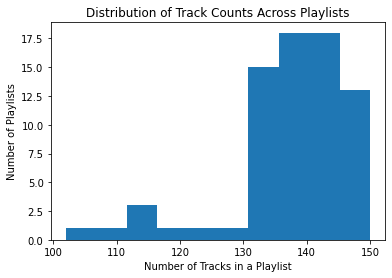

In [34]:
# Distribution of tracks across playlists

print("First 5 playlist IDs and their number of tracks:", tracks_per_plist[:5])

# Plot
plt.hist(tracks_per_plist, bins=10)
plt.xlabel('Number of Tracks in a Playlist')
plt.ylabel('Number of Playlists')
plt.title('Distribution of Track Counts Across Playlists')
plt.show()

Number of unique tracks: 7704
Number of repeated tracks: 1360
Mean number of times a track is repeated: 2.6051470588235293
Standard deviation of number of times a track is repeated: 1.087410047395203


Text(0.5, 1.0, 'Frequency of Repeated Tracks vs Number of Times Track is Repeated')

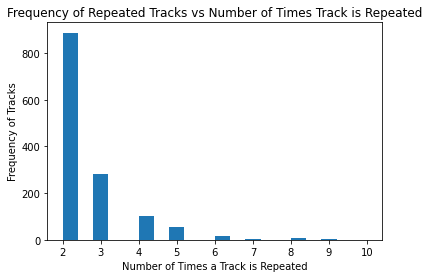

In [35]:
# Track repetitions across playlists
# A repeated track appears in at least 2 playlists

track_uri_counts = final_df.groupby('Track URI').size()
repeated_tracks = track_uri_counts[track_uri_counts > 1]

# Stats
print("Number of unique tracks:", final_df['Track URI'].nunique())
print("Number of repeated tracks:", len(repeated_tracks))
print("Mean number of times a track is repeated:", repeated_tracks.mean())
print("Standard deviation of number of times a track is repeated:", repeated_tracks.std())

# Plot
plt.hist(repeated_tracks, bins=20)
plt.xlabel('Number of Times a Track is Repeated')
plt.ylabel('Frequency of Tracks')
plt.title('Frequency of Repeated Tracks vs Number of Times Track is Repeated')

#### Save dataframe to csv

In [38]:
final_df.to_csv('data/playlist_dataset.csv', index=False)
